## Librerías

In [1]:
import numpy as np
import rasterio
import rasterstats

import earthpy.plot as ep
import os
import datetime


import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator


import pandas as pd
import geopandas as gpd



In [2]:
parcelas = gpd.read_file(r"C:\Users\DELL\PycharmProjects\Tesis\Poligonos\SHP\Rancho_SantaAnita\Lote_Rancho_Santa_Anita.shp")

parcelas_wgs = parcelas.to_crs(4326)

In [3]:
agera_path = r"C:\Users\DELL\Documents\Tesis_sugarCane\pruebas"

In [4]:
et_images = {}


for i in os.listdir(agera_path):
    if i.endswith('.tif'):
        full_path = os.path.join(agera_path, i)
        path_parts = full_path.split('_')
        last_part = path_parts[-1]
        fecha, extension = tuple(last_part.split('.'))
        year, month, day = int(fecha[0:4]), int(fecha[4:6]), int(fecha[6:8])
        fecha_final = datetime.date(year, month, day)
        
        et_images[fecha_final] = full_path

In [5]:
stats_eva = {}

parcelas_wgs['geometry'] = parcelas_wgs['geometry'].centroid

for fecha, image_path in et_images.items():
    #image_str = str(image)
    #fecha = f'{image_str[16:20]}-{image_str[20:22]}-{image_str[22:24]}'
    src = rasterio.open(image_path)
    et = src.read(1)
    #earthpy.plot.plot_bands(et)
    transform = src.transform
    
    pixel_values = []
    
    for geom in parcelas_wgs['geometry']:
        x, y = geom.x, geom.y
        row, col = src.index(x, y)
        pixel_val = src.read(1, window=((row, row+1), (col, col+1)))
        pixel_values.append(pixel_val[0][0])
        
    stats_eva[fecha] = {'Imagen': image_path, 'Pixel_values': pixel_values}

C:\Users\DELL\AppData\Local\Temp\ipykernel_12264\2709913156.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  parcelas_wgs['geometry'] = parcelas_wgs['geometry'].centroid


In [6]:
fechas = []
imagenes = []
columnas_pixel = {}

for fecha, valores in stats_eva.items():
    fechas.append(fecha)
    imagenes.append(valores['Imagen'])
    for i, valor in enumerate(valores['Pixel_values']):
        if i not in columnas_pixel:
            columnas_pixel[i] = []
        columnas_pixel[i].append(valor)

# Crear el DataFrame
df_et = pd.DataFrame({'Fecha': fechas, 'Imagen': imagenes, **columnas_pixel})

# Mostrar el DataFrame
df_et

,Fecha,Imagen,0,1,2,3,4,5,6
0,2021-01-01,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,1.972649,1.972649,1.972649,1.972649,1.972649,1.972649,1.972649
1,2021-01-02,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,2.167568,2.167568,2.167568,2.167568,2.167568,2.167568,2.167568
2,2021-01-03,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,2.721180,2.721180,2.721180,2.721180,2.721180,2.721180,2.721180
3,2021-01-04,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,2.894043,2.894043,2.894043,2.894043,2.894043,2.894043,2.894043
4,2021-01-05,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,2.901426,2.901426,2.901426,2.901426,2.901426,2.901426,2.901426
...,...,...,...,...,...,...,...,...,...
809,2023-03-21,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,5.143841,5.143841,5.143841,5.143841,5.143841,5.143841,5.143841
810,2023-03-22,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,4.972660,4.972660,4.972660,4.972660,4.972660,4.972660,4.972660
811,2023-03-23,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,4.922693,4.922693,4.922693,4.922693,4.922693,4.922693,4.922693
812,2023-03-24,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,5.721313,5.721313,5.721313,5.721313,5.721313,5.721313,5.721313


In [7]:
df_et['acumulado_parcela0'] = df_et[0].cumsum()

In [16]:
def plot_data(data, columns: list, title):
    
    fig_1, ax_1 = plt.subplots(figsize=(14, 7))
    plt.style.use('_mpl-gallery')
    
    ax_1.xaxis.set_major_locator(MonthLocator(interval=1))
    ax_1.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    ax_1.yaxis.grid(True, zorder=0)
    
    ax_1.set_title(title)
    ax_1.set_xlabel('Fecha')
    ax_1.set_ylabel('Evapotranspiración de referencia $mm día^{-1}$')
    
    ax_1.plot(data[columns[0]], data[columns[1]], linewidth=1, color='b')
    ax_1.scatter(data[columns[0]], data[columns[1]], color='red')
    
    
    plt.xticks(rotation=90)
    plt.show()

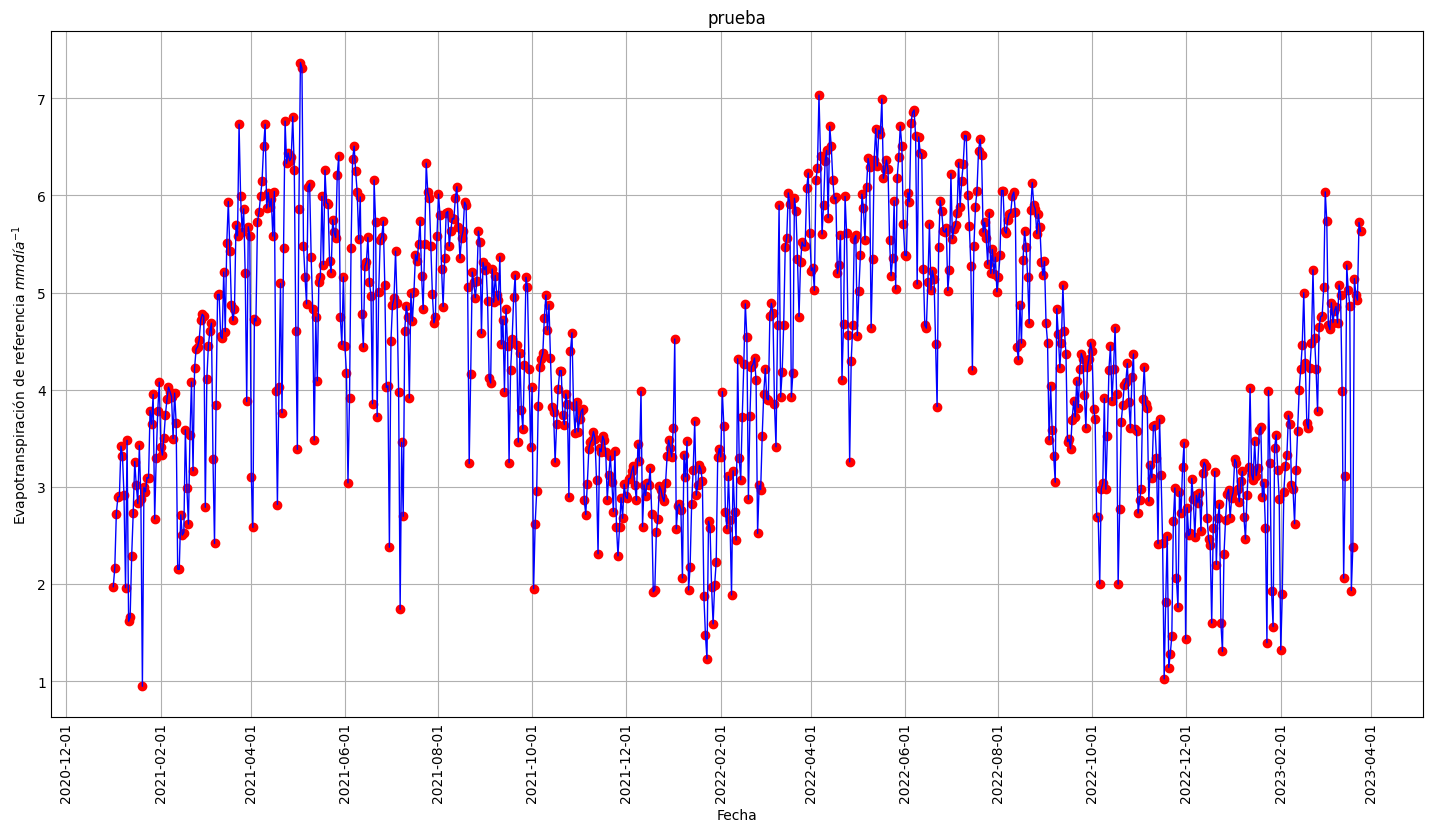

In [26]:
plot_data(df_et, columns=['Fecha', 0], title='prueba')

## Hasta aquí la parte de ET

In [3]:
def ndvi(image):
    nir = image.read(4)
    red = image.read(3)

    nir_dtype = nir.astype('float64')
    red_dtype = red.astype('float64')

    ndvi_calc = (nir_dtype - red_dtype) / (nir_dtype + red_dtype)

    return ndvi_calc

In [4]:
sen_images_path = r"C:\Users\DELL\PycharmProjects\Tesis\Tesis_caña"
sen_images = {}

try:
    for file in os.listdir(sen_images_path):
        if file.endswith('.tif'):
            full_path = os.path.join(sen_images_path, file)
            splited_file_name = file.split('_')
            year, month, day = (int(splited_file_name[4][0:4]), int(splited_file_name[4][4:6]),
                                int(splited_file_name[4][6:8]))
            fecha = datetime.date(year, month, day)
            sen_images[fecha] = full_path
except ValueError:
    print('algo salio mal')

stats_ndvi = {}

try:
    for fecha, image_path in sen_images.items():

        imagen = image_path.split('_')
        src = rasterio.open(image_path)
        transform = src.transform
        ndvi_band = ndvi(src)

        for num, feature in enumerate(rasterstats.zonal_stats(r'C:\Users\DELL\PycharmProjects\Tesis\Poligonos\SHP'
                                                              r'\Rancho_SantaAnita\Lote_Rancho_Santa_Anita.shp',
                                                              ndvi_band, affine=transform, stats=['mean', 'max',
                                                                                                  'min'])):
            # print(num, feature)

            key = f"{num + 1}_{imagen[-3]}"
            stats_ndvi[key] = {
                'Imagen': imagen[-3],
                'Fecha': fecha,
                'Num_parcela': num + 1,
                'mean_ndvi': feature['mean'],
                'max_ndvi': feature['max'],
                'min_ndvi': feature['min']
            }
    ndvi_df = pd.DataFrame.from_dict(stats_ndvi, orient='index')
    ndvi_df.reset_index(inplace=True)
except TypeError:
    print('chin')

C:\Users\DELL\PycharmProjects\Tesis\venv\Lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


In [92]:
ndvi_df_par1 = ndvi_df.loc[ndvi_df['Num_parcela'] == 1]

In [93]:
ndvi_df_par1['Fecha'] = ndvi_df_par1["Fecha"].astype('datetime64[ns]')

C:\Users\DELL\AppData\Local\Temp\ipykernel_10980\2693139808.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndvi_df_par1['Fecha'] = ndvi_df_par1["Fecha"].astype('datetime64[ns]')


In [94]:
ndvi_df_par1

,index,Imagen,Fecha,Num_parcela,mean_ndvi,max_ndvi,min_ndvi
0,1_20210106T170711,20210106T170711,2021-01-06,1,0.645224,0.744574,0.341822
7,1_20210116T170641,20210116T170641,2021-01-16,1,0.535529,0.621915,0.378947
14,1_20210126T170601,20210126T170601,2021-01-26,1,0.642812,0.746551,0.426783
21,1_20210131T170529,20210131T170529,2021-01-31,1,0.635125,0.737444,0.409997
28,1_20210205T170501,20210205T170501,2021-02-05,1,0.536146,0.656266,0.297883
...,...,...,...,...,...,...,...
651,1_20230720T165849,20230720T165849,2023-07-20,1,0.509319,0.664137,0.315482
658,1_20230804T165851,20230804T165851,2023-08-04,1,0.549478,0.712224,0.368612
665,1_20230809T165849,20230809T165849,2023-08-09,1,0.652791,0.815465,0.419420
672,1_20230814T165901,20230814T165901,2023-08-14,1,0.720526,0.834445,0.509035


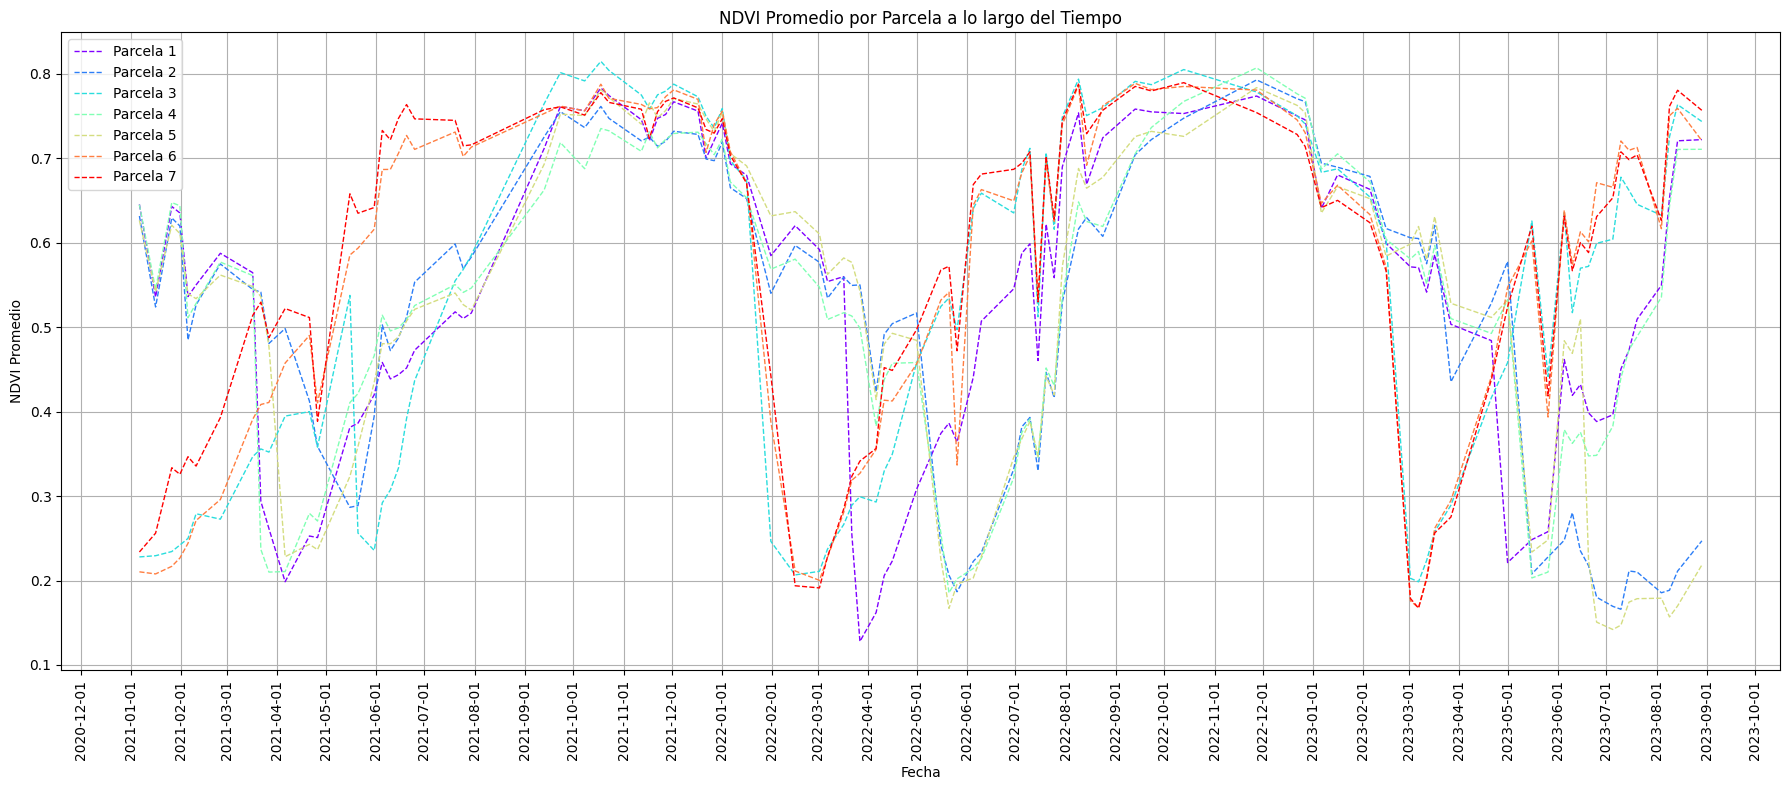

In [6]:
fig, ax = plt.subplots(figsize=(18, 8))

colores = plt.cm.rainbow(np.linspace(0, 1, len(ndvi_df['Num_parcela'].unique())))

# Itera sobre cada parcela y grafica el NDVI promedio a lo largo del tiempo
for parcela_id, color in zip(ndvi_df['Num_parcela'].unique(), colores):
    parcela_data = ndvi_df[ndvi_df['Num_parcela'] == parcela_id]
    ax.plot(parcela_data['Fecha'], parcela_data['mean_ndvi'], label=f'Parcela {parcela_id}', linewidth=1, color=color, linestyle='dashed')

# Etiqueta los ejes y el título del gráfico
ax.xaxis.set_major_locator(MonthLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Fecha')
ax.set_ylabel('NDVI Promedio')
ax.set_title('NDVI Promedio por Parcela a lo largo del Tiempo')

# Agrega una leyenda para identificar cada parcela en el gráfico
ax.legend()

plt.grid(True)
plt.xticks(rotation=90)
# Muestra el gráfico
plt.tight_layout()
#plt.savefig(r'C:\Users\DELL\PycharmProjects\Tesis\graficas\ndvi_mean.jpg', dpi=300)
plt.show()

In [7]:
def plot_data2(data, column, title):
    
    fig, ax = plt.subplots(figsize=(14, 7))
    plt.style.use('_mpl-gallery')
    
    ax.xaxis.set_major_locator(MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
    ax.yaxis.grid(True, zorder=0)
    
    ax.set_title(title)
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Valor')
    
    ax.plot(data.index, data[column], linewidth=1)
    ax.scatter(data.index, data[column], color='red')
    
    plt.xticks(rotation=90)
    plt.show()

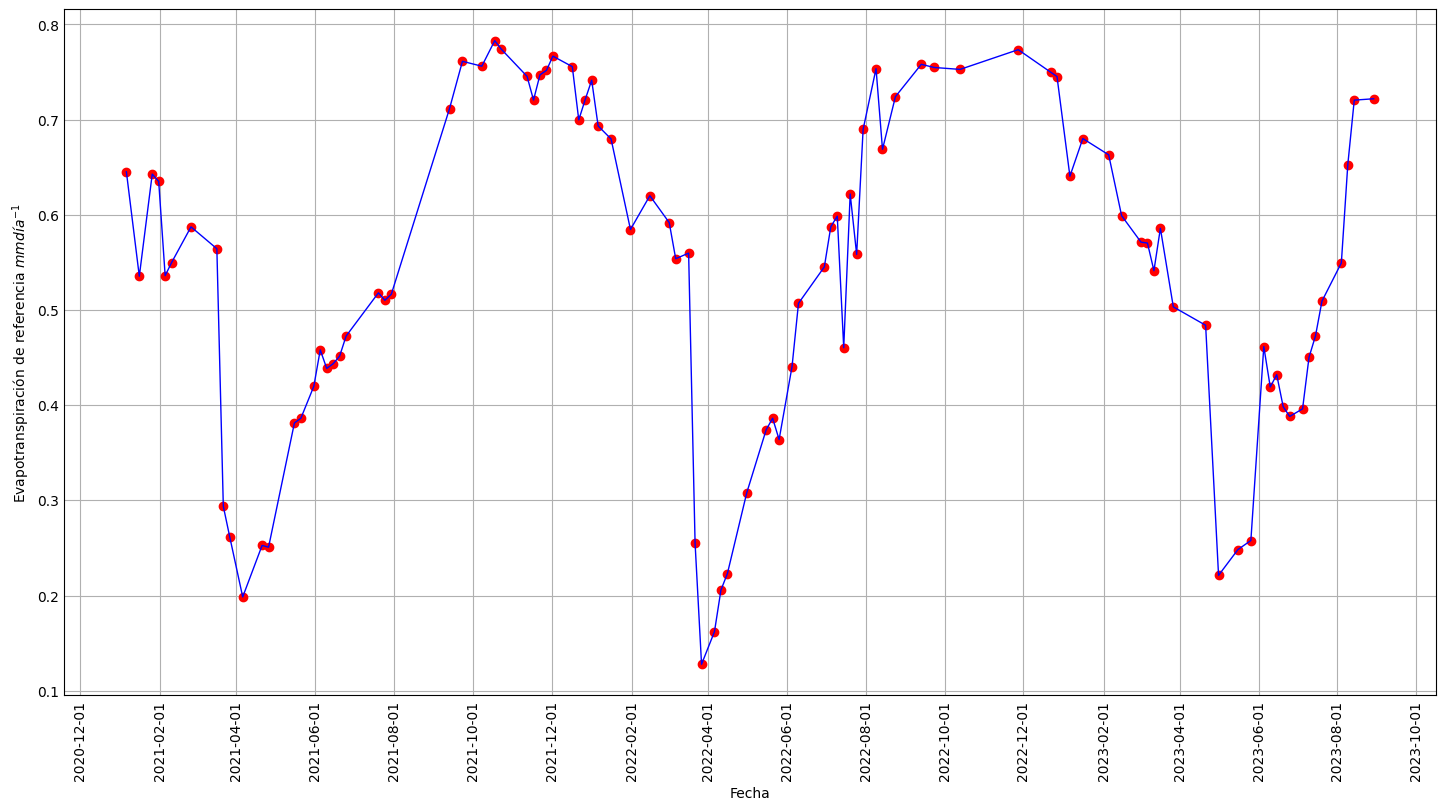

In [95]:
plot_data(ndvi_df_par1, columns=['Fecha', 'mean_ndvi'], title='')

In [12]:
et_data = pd.read_csv(r'C:\Users\DELL\PycharmProjects\Tesis\dataframes\et_RSA.csv')

In [23]:
et_data['Fecha'] = et_data['Fecha'].astype('datetime64[ns]')

In [97]:
merged_p1 = pd.merge(ndvi_df_par1, et_data, on='Fecha')

In [98]:
merged_p1

,index,Imagen_x,Fecha,Num_parcela,mean_ndvi,max_ndvi,min_ndvi,Unnamed: 0,Imagen_y,0,1,2,3,4,5,6
0,1_20210106T170711,20210106T170711,2021-01-06,1,0.645224,0.744574,0.341822,5,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,3.418571,3.418571,3.418571,3.418571,3.418571,3.418571,3.418571
1,1_20210116T170641,20210116T170641,2021-01-16,1,0.535529,0.621915,0.378947,15,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,3.016875,3.016875,3.016875,3.016875,3.016875,3.016875,3.016875
2,1_20210126T170601,20210126T170601,2021-01-26,1,0.642812,0.746551,0.426783,25,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,3.644999,3.644999,3.644999,3.644999,3.644999,3.644999,3.644999
3,1_20210131T170529,20210131T170529,2021-01-31,1,0.635125,0.737444,0.409997,30,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,4.076692,4.076692,4.076692,4.076692,4.076692,4.076692,4.076692
4,1_20210205T170501,20210205T170501,2021-02-05,1,0.536146,0.656266,0.297883,35,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,3.901715,3.901715,3.901715,3.901715,3.901715,3.901715,3.901715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1_20230215T170401,20230215T170401,2023-02-15,1,0.599104,0.694915,0.381067,775,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,4.459202,4.459202,4.459202,4.459202,4.459202,4.459202,4.459202
76,1_20230302T170219,20230302T170219,2023-03-02,1,0.571326,0.672085,0.311429,790,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,6.036061,6.036061,6.036061,6.036061,6.036061,6.036061,6.036061
77,1_20230307T170141,20230307T170141,2023-03-07,1,0.570349,0.680217,0.324786,795,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,4.690739,4.690739,4.690739,4.690739,4.690739,4.690739,4.690739
78,1_20230312T170119,20230312T170119,2023-03-12,1,0.541367,0.649827,0.310964,800,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,4.978452,4.978452,4.978452,4.978452,4.978452,4.978452,4.978452


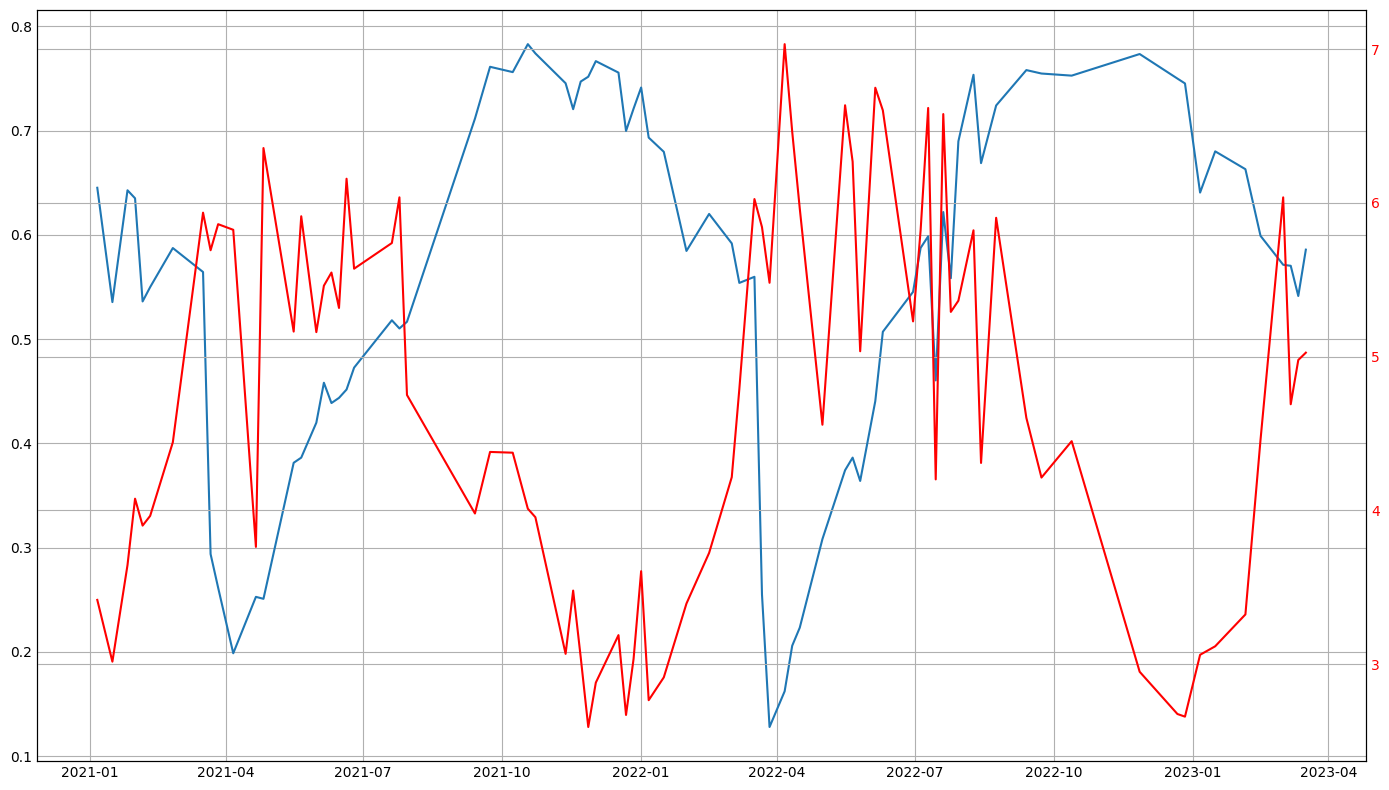

In [99]:

    
fig, ax1 = plt.subplots(figsize=(14, 8))
    
ax1.plot(merged_p1['Fecha'], merged_p1['mean_ndvi'])
ax1.tick_params(axis='y')
    
ax2 = ax1.twinx()
    
ax2.plot(merged_p1['Fecha'], merged_p1['4'], color='r')
ax2.tick_params(axis='y', labelcolor='r')
    
fig.tight_layout()
plt.show()

In [100]:
corr = merged_p1['mean_ndvi'].corr(merged_p1['4'])

In [101]:
corr

-0.6295328160568977

In [102]:
merged_p1['kc'] = 1.15 * merged_p1['mean_ndvi'] + 0.17

In [103]:
merged_p1['et_c'] = merged_p1['kc'] * merged_p1['4']

In [104]:
merged_p1

,index,Imagen_x,Fecha,Num_parcela,mean_ndvi,max_ndvi,min_ndvi,Unnamed: 0,Imagen_y,0,1,2,3,4,5,6,kc,et_c
0,1_20210106T170711,20210106T170711,2021-01-06,1,0.645224,0.744574,0.341822,5,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,3.418571,3.418571,3.418571,3.418571,3.418571,3.418571,3.418571,0.912008,3.117765
1,1_20210116T170641,20210116T170641,2021-01-16,1,0.535529,0.621915,0.378947,15,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,3.016875,3.016875,3.016875,3.016875,3.016875,3.016875,3.016875,0.785858,2.370836
2,1_20210126T170601,20210126T170601,2021-01-26,1,0.642812,0.746551,0.426783,25,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,3.644999,3.644999,3.644999,3.644999,3.644999,3.644999,3.644999,0.909234,3.314156
3,1_20210131T170529,20210131T170529,2021-01-31,1,0.635125,0.737444,0.409997,30,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,4.076692,4.076692,4.076692,4.076692,4.076692,4.076692,4.076692,0.900393,3.670626
4,1_20210205T170501,20210205T170501,2021-02-05,1,0.536146,0.656266,0.297883,35,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,3.901715,3.901715,3.901715,3.901715,3.901715,3.901715,3.901715,0.786568,3.068963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1_20230215T170401,20230215T170401,2023-02-15,1,0.599104,0.694915,0.381067,775,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,4.459202,4.459202,4.459202,4.459202,4.459202,4.459202,4.459202,0.858970,3.830319
76,1_20230302T170219,20230302T170219,2023-03-02,1,0.571326,0.672085,0.311429,790,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,6.036061,6.036061,6.036061,6.036061,6.036061,6.036061,6.036061,0.827024,4.991970
77,1_20230307T170141,20230307T170141,2023-03-07,1,0.570349,0.680217,0.324786,795,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,4.690739,4.690739,4.690739,4.690739,4.690739,4.690739,4.690739,0.825902,3.874090
78,1_20230312T170119,20230312T170119,2023-03-12,1,0.541367,0.649827,0.310964,800,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,4.978452,4.978452,4.978452,4.978452,4.978452,4.978452,4.978452,0.792572,3.945780


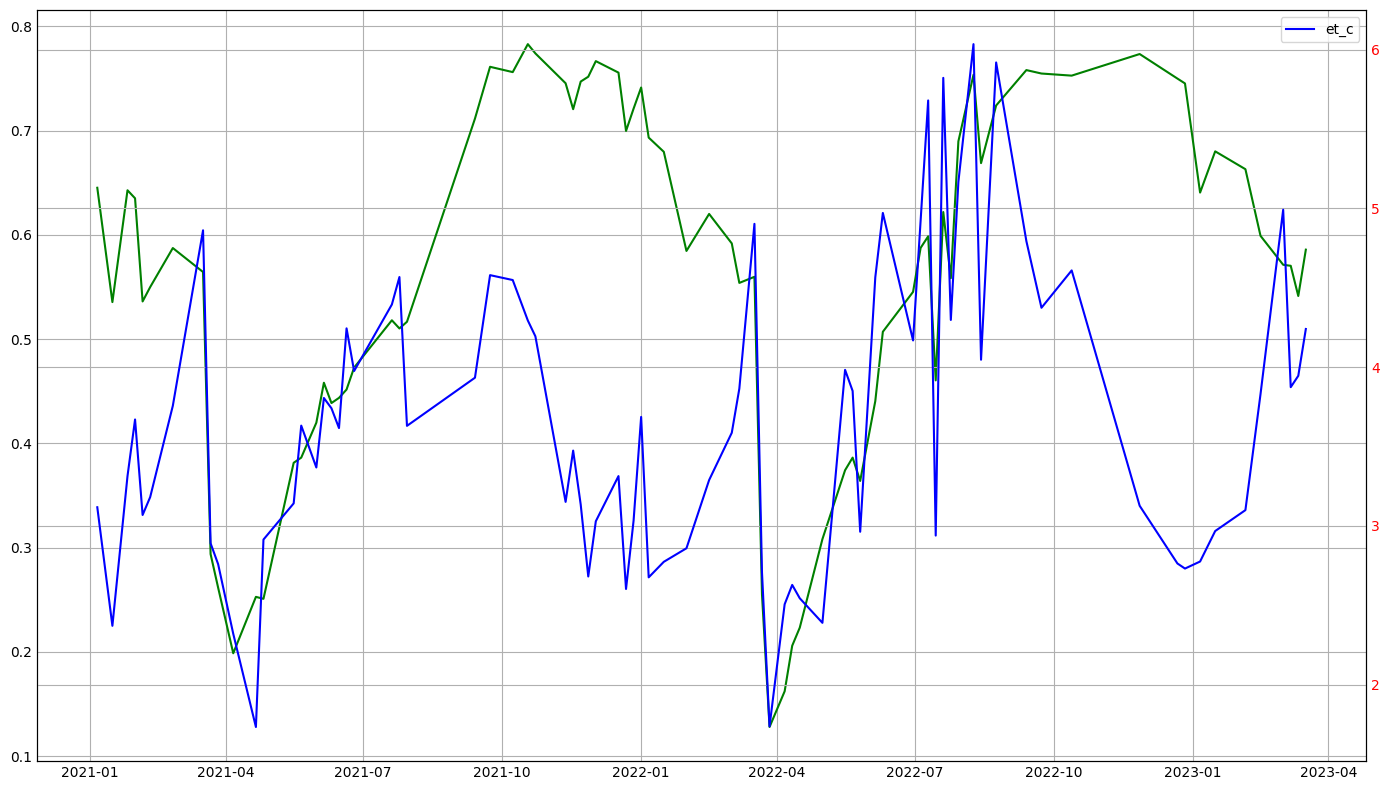

In [118]:
fig, ax1 = plt.subplots(figsize=(14, 8))
    
ax1.plot(merged_p1['Fecha'], merged_p1['mean_ndvi'], color='g', label='ndvi')
ax1.tick_params(axis='y')
    
ax2 = ax1.twinx()
    
ax2.plot(merged_p1['Fecha'], merged_p1['et_c'], color='b', label='et_c')
#ax2.plot(merged_p1['Fecha'], merged_p1['4'], color='r', label='et')
ax2.tick_params(axis='y', labelcolor='r')

plt.legend()
    
fig.tight_layout()
plt.show()

In [116]:
corr2 = merged_p1['mean_ndvi'].corr(merged_p1['et_c'])

In [117]:
corr2

0.3876271915839336

## estadisticas

In [3]:
cierre_agro = pd.read_csv(r'C:\Users\DELL\PycharmProjects\Tesis\dataframes\Cierre_agr_mun_2022.csv', encoding='ISO-8859-9')

C:\Users\DELL\AppData\Local\Temp\ipykernel_17460\2294302229.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  cierre_agro = pd.read_csv(r'C:\Users\DELL\PycharmProjects\Tesis\dataframes\Cierre_agr_mun_2022.csv', encoding='ISO-8859-9')


In [4]:
cierre_agro

,Anio,Idestado,Nomestado,Idddr,Nomddr,Idcader,Nomcader,Idmunicipio,Nommunicipio,Idciclo,...,Nomunidad,Idcultivo,Nomcultivo,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Rendimiento,Preciomediorural,Valorproduccion
0,2022,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,...,Tonelada,5490000,Avena forrajera en verde,1180.0,1180.0,0.0,31270,26.50,565.13,17671615.10
1,2022,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,...,Tonelada,5670000,Brócoli,45.0,45.0,0.0,810,18.00,3805.33,3082317.30
2,2022,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,...,Tonelada,5900000,Cebada forrajera en verde,10.0,10.0,0.0,280,28.00,590.00,165200.00
3,2022,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,...,Tonelada,9090000,Triticale forrajero en verde,300.0,300.0,0.0,9180,30.60,550.00,5049000.00
4,2022,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,...,Tonelada,15050000,Pastos y praderas,527.5,527.5,0.0,26290.6,49.84,520.00,13671112.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37550,2022,32,Zacatecas,190,Jalpa,4,Jalpa,19,Jalpa,3,...,Tonelada,7960000,Nuez,10.0,10.0,0.0,25.4,2.54,48500.00,1231900.00
37551,2022,32,Zacatecas,190,Jalpa,4,Jalpa,19,Jalpa,3,...,Tonelada,9130000,Uva,20.0,20.0,0.0,190.0,9.50,27000.00,5130000.00
37552,2022,32,Zacatecas,190,Jalpa,4,Jalpa,19,Jalpa,3,...,Tonelada,15050000,Pastos y praderas,86.0,86.0,0.0,4602.1,53.51,700.00,3221470.00
37553,2022,32,Zacatecas,190,Jalpa,4,Jalpa,19,Jalpa,3,...,Tonelada,5050000,Agave,38.0,4.0,0.0,370.0,92.50,24800.00,9176000.00


In [12]:
cierre_ddr162 = cierre_agro.loc[(cierre_agro['Idddr'] == 162) & (cierre_agro['Idcultivo'] == 5820000)]

In [13]:
cierre_ddr162

,Anio,Idestado,Nomestado,Idddr,Nomddr,Idcader,Nomcader,Idmunicipio,Nommunicipio,Idciclo,...,Nomunidad,Idcultivo,Nomcultivo,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Rendimiento,Preciomediorural,Valorproduccion
31849,2022,28,Tamaulipas,162,Mante,1,Mante,4,Antiguo Morelos,3,...,Tonelada,5820000,Caña de azúcar,817.00,650.00,0.0,22750,35.0,992.0,2.256800e+07
31853,2022,28,Tamaulipas,162,Mante,1,Mante,4,Antiguo Morelos,3,...,Tonelada,5820000,Caña de azúcar,4824.43,3060.17,0.0,85684.76,28.0,992.0,8.499928e+07
31872,2022,28,Tamaulipas,162,Mante,1,Mante,21,El Mante,3,...,Tonelada,5820000,Caña de azúcar,10688.25,10082.25,0.0,604935,60.0,1095.0,6.624038e+08
31889,2022,28,Tamaulipas,162,Mante,1,Mante,28,Nuevo Morelos,3,...,Tonelada,5820000,Caña de azúcar,4975.70,3836.75,0.0,109731.05,28.6,992.0,1.088532e+08
31896,2022,28,Tamaulipas,162,Mante,2,Xicoténcatl,11,Gómez Farías,3,...,Tonelada,5820000,Caña de azúcar,6626.78,5280.00,0.0,306240,58.0,1095.0,3.353328e+08
31914,2022,28,Tamaulipas,162,Mante,2,Xicoténcatl,43,Xicoténcatl,3,...,Tonelada,5820000,Caña de azúcar,17863.61,11965.24,0.0,717914.4,60.0,1095.0,7.861163e+08
31934,2022,28,Tamaulipas,162,Mante,3,Ocampo,29,Ocampo,3,...,Tonelada,5820000,Caña de azúcar,483.93,450.00,0.0,33750,75.0,992.0,3.348000e+07
31937,2022,28,Tamaulipas,162,Mante,3,Ocampo,29,Ocampo,3,...,Tonelada,5820000,Caña de azúcar,13994.78,10424.23,0.0,500363.04,48.0,992.0,4.963601e+08
31974,2022,28,Tamaulipas,162,Mante,4,Animas,21,El Mante,3,...,Tonelada,5820000,Caña de azúcar,1008.25,500.00,0.0,31000,62.0,1095.0,3.394500e+07


In [14]:
total = cierre_ddr162['Sembrada'].sum()

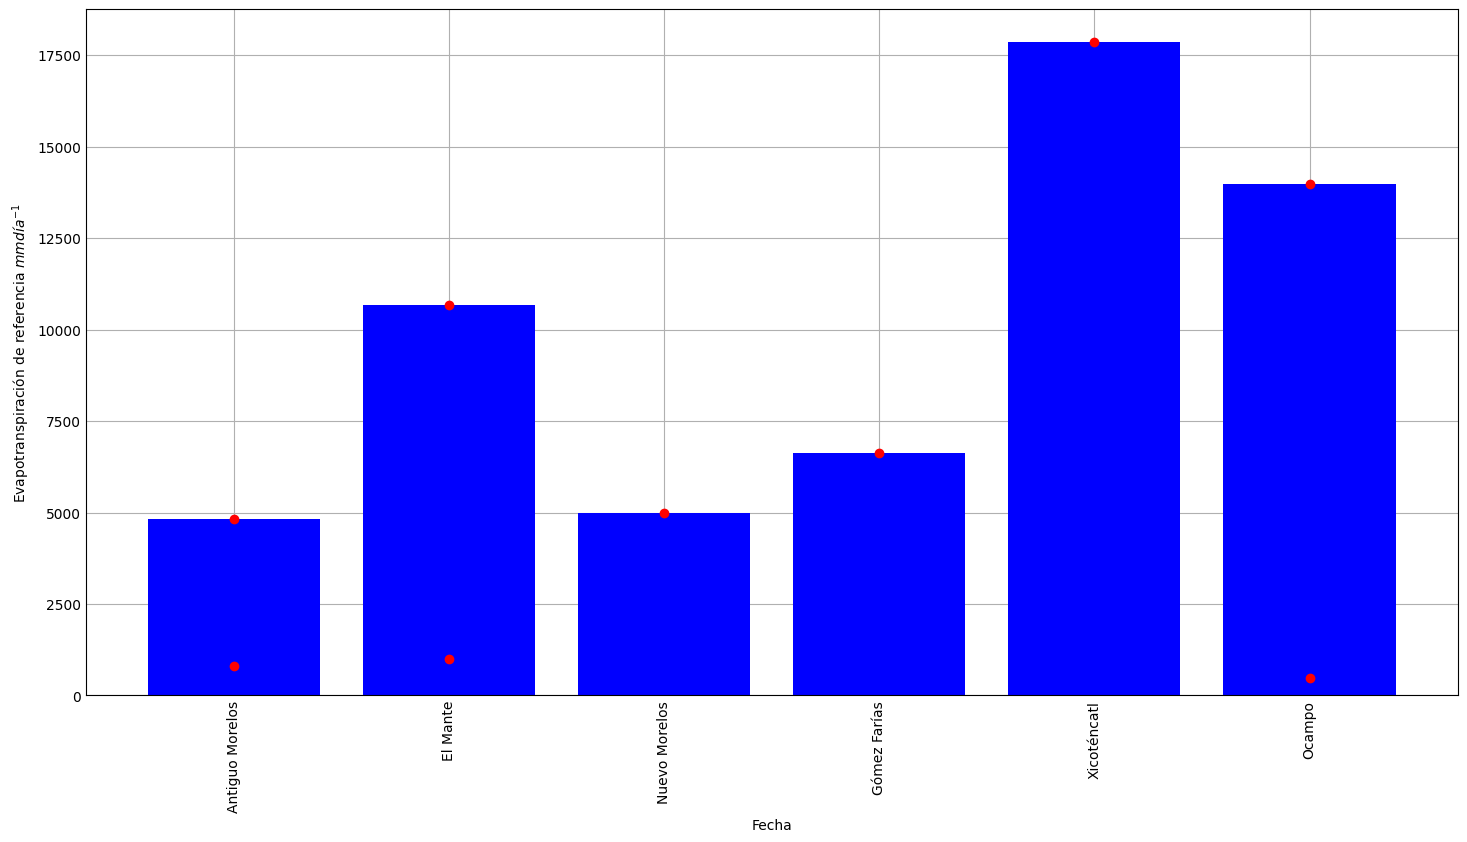

In [23]:
plot_data(cierre_ddr162, columns=['Nommunicipio', 'Sembrada'], title='')

In [80]:
parcela = pd.read_csv(r"C:\Users\DELL\PycharmProjects\Tesis\dataframes\parcela10.csv")

In [81]:
parcela['Fecha'] = parcela['Unnamed: 0'].astype('datetime64[ns]')

In [52]:
parcela

,Unnamed: 0,Parcela,mean,min,max,Fecha
0,2022-01-01,5,0.742436,0.397920,0.817429,2022-01-01
1,2022-01-06,5,0.694405,0.355444,0.794860,2022-01-06
2,2022-01-16,5,0.680427,0.367735,0.757648,2022-01-16
3,2022-01-31,5,0.585178,0.312327,0.709720,2022-01-31
4,2022-02-15,5,0.621130,0.302249,0.726455,2022-02-15
5,2022-03-02,5,0.592820,0.269449,0.702206,2022-03-02
6,2022-03-17,5,0.560504,0.296825,0.672821,2022-03-17
7,2022-03-22,5,0.254916,0.209148,0.371754,2022-03-22
8,2022-03-27,5,0.485091,0.000000,107.426230,2022-03-27
9,2022-04-06,5,0.161885,0.113788,0.299404,2022-04-06


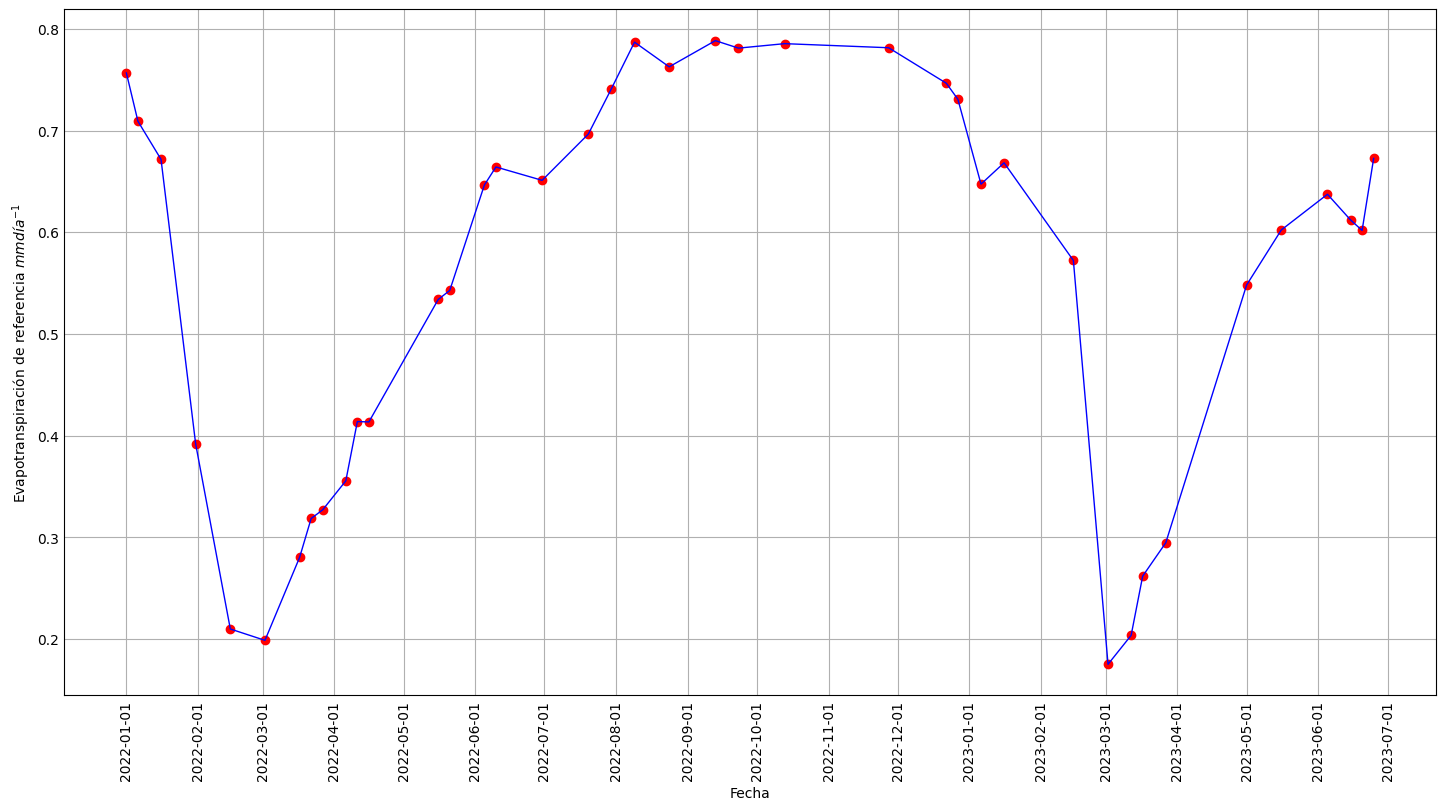

In [82]:
plot_data(parcela, columns=['Fecha', 'mean'], title='')